d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


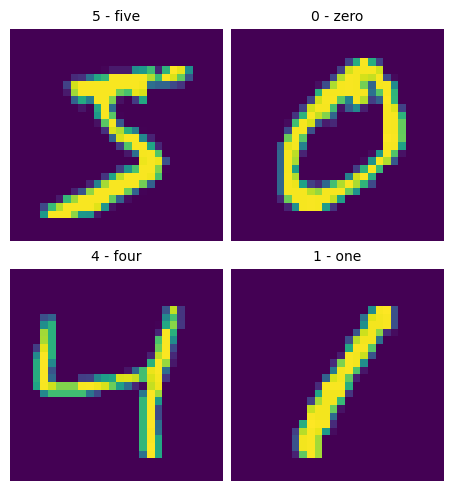

15738
path                                         module                                       input size               output size              params    buffers   
__main__.CNN/c1/0                            torch.nn.modules.conv.Conv2d                 (1, 1, 28, 28)           (1, 16, 25, 25)          272       0         
__main__.CNN/c1/1                            torch.nn.modules.pooling.MaxPool2d           (1, 16, 25, 25)          (1, 16, 12, 12)          0         0         
__main__.CNN/c1/2                            torch.nn.modules.activation.ReLU             (1, 16, 12, 12)          (1, 16, 12, 12)          0         0         
__main__.CNN/c2/0                            torch.nn.modules.conv.Conv2d                 (1, 16, 12, 12)          (1, 32, 10, 10)          4640      0         
__main__.CNN/c2/1                            torch.nn.modules.pooling.MaxPool2d           (1, 32, 10, 10)          (1, 32, 5, 5)            0         0         
__main__.CNN/c2/2           

In [1]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets import MNIST
dstrain, dstest = MNIST.get_mnist_classification()
dstrain.preview()

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = conv(1, 16, 4, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2,2))
        self.c2 = conv(16, 32, 3, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2, 2))
        self.c3 = conv(32, 64, 2, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2, 2))
        self.linear = linear(256, 10, act=nn.Softmax(dim=1), flatten=True)
    
    def forward(self,x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.linear(x)
        return x

print(count_parameters(CNN()))
summary(CNN(), (1, 1, 28,28))
#torchinfo.summary(CNN(), (1, 1, 40))

# No zero_grad (because forgot to add it) - 61% test accuracy
So here I forgot to use zero_grad and it still converged all the way to 60% accuracy. Seems like strong long term momentum might be beneficial

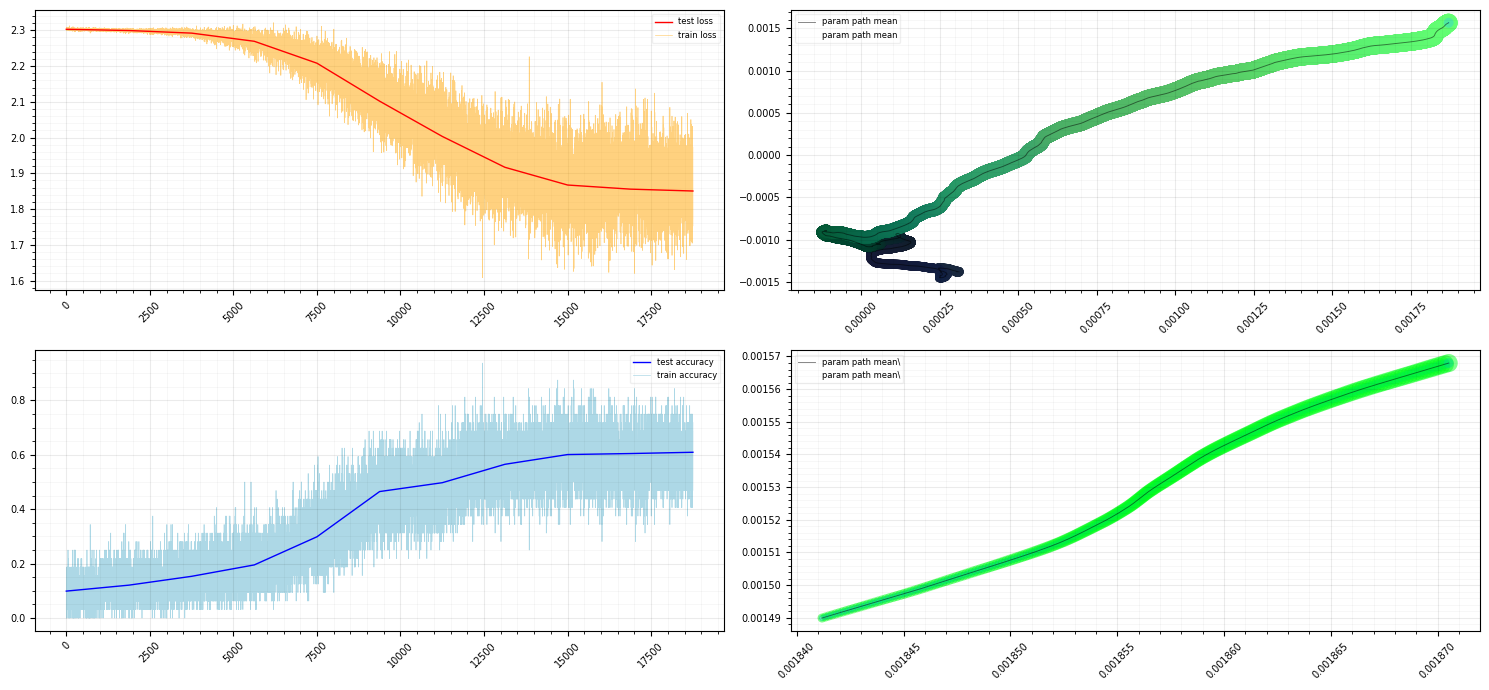

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 58.96s/ops, elapsed: 08m:50s, rem: 58.96s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 207.70ops/s, elapsed: 1.50s, rem: 5ms | 
train loss:                              last = 1.753, min = 1.608, max = 2.321
test loss:                               last = 1.856, min = 1.856, max = 2.303
train accuracy:                          last = 0.719, min = 0.000, max = 0.938
test accuracy:                           last = 0.605, min = 0.099, max = 0.605

test loss: min: 1.8505; max: 2.3029; last: 1.8505
test accuracy: min: 0.0989; max: 0.6095; last: 0.6095
param mean: min: 0.0001; max: 0.0039; last: 0.0039
param var: min: 0.0026; max: 0.0231; last: 0.0231
param min: min: -0.4349; max: -0.2451; last: -0.4349
param max: min: 0.2476; max: 0.4364; last: 0.4364
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0003; last: 0.0000
time: min: 3.7129; max: 594.4693; last: 594.4693
lr: min: 0.0010; max: 0.0010; last: 0.0010
train loss: min: 1.6081; max: 2.3212; last: 1.7533
train accuracy: min: 0.0000; max: 0.9375; last: 0.7188
last updates std: min: 0.0000; max: 0.0000; last: 0.0000


In [5]:
from torchzero.optim import RandomGrad
with seeded_rng(): MODEL = CNN()
LRGRAD = 1e-3
LR = 1e-5
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomGrad(MODEL.parameters(), lr=LRGRAD, opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFree(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomGrad {LRGRAD:.0e} adamw{LR:.0e}"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# RandomGrad 1e-3 + AdamW 1e-3 - 60% test accuracy
1e-3 for RandomGrad seems to be too high.

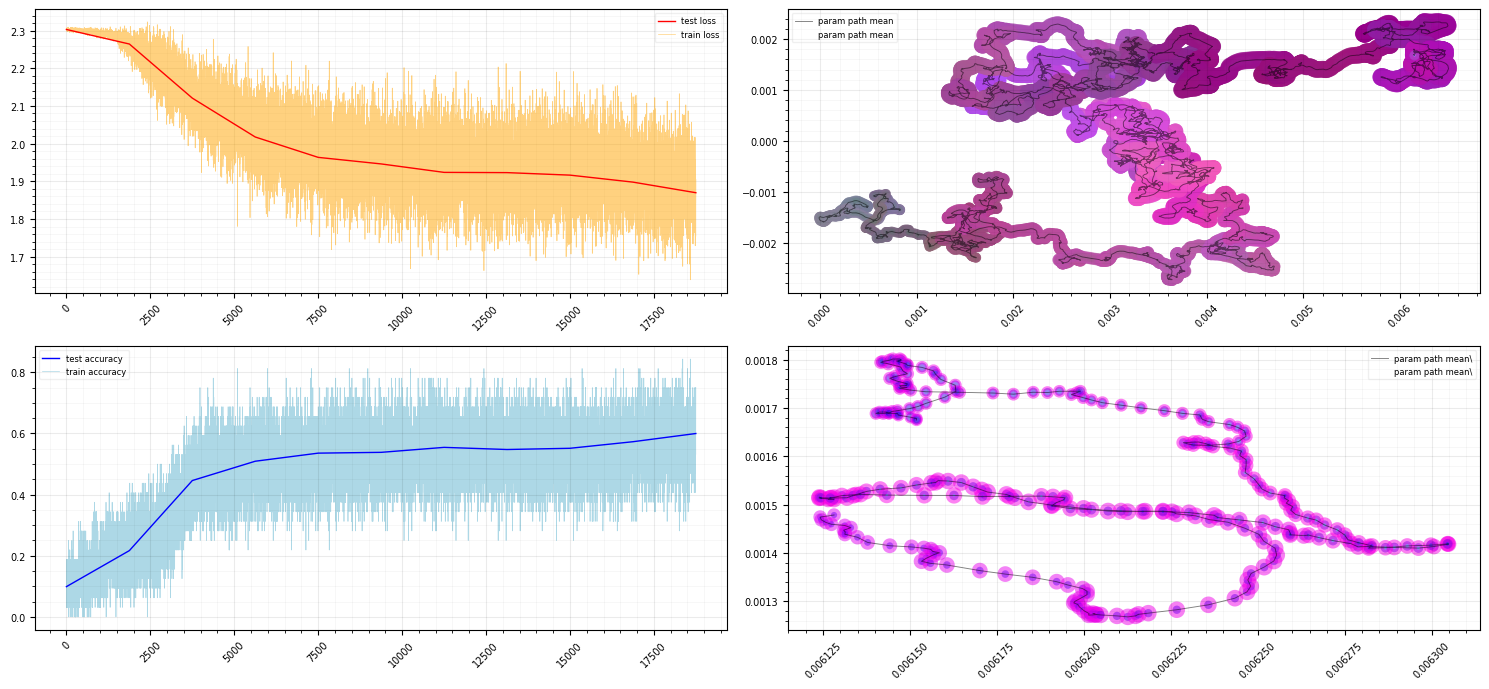

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 49.32s/ops, elapsed: 07m:23s, rem: 49.32s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 221.90ops/s, elapsed: 1.41s, rem: 5ms | 
train loss:                              last = 1.755, min = 1.639, max = 2.323
test loss:                               last = 1.898, min = 1.898, max = 2.303
train accuracy:                          last = 0.750, min = 0.000, max = 0.844
test accuracy:                           last = 0.573, min = 0.099, max = 0.573

test loss: min: 1.8698; max: 2.3029; last: 1.8698
test accuracy: min: 0.0989; max: 0.5999; last: 0.5999
param mean: min: -0.0001; max: 0.0032; last: 0.0031
param var: min: 0.0026; max: 0.0179; last: 0.0179
param min: min: -0.5540; max: -0.2481; last: -0.5470
param max: min: 0.2467; max: 0.6610; last: 0.6450
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0017; max: 0.0195; last: 0.0017
time: min: 1.5843; max: 491.9435; last: 491.9435
lr: min: 0.0010; max: 0.0010; last: 0.0010
train loss: min: 1.6388; max: 2.3231; last: 1.7548
train accuracy: min: 0.0000; max: 0.8438; last: 0.7500
last updates std: min: 0.0001; max: 0.0003; last: 0.0001


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [4]:
from torchzero.optim import RandomGrad
with seeded_rng(): MODEL = CNN()
LRGRAD = 1e-3
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomGrad(MODEL.parameters(), lr=LRGRAD, opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomGrad {LRGRAD:.0e} adamw{LR:.0e}"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# RandomGrad 1e-5 + AdamW 1e-3 - 68% test accuracy
1e-5 for RandomGrad seems better

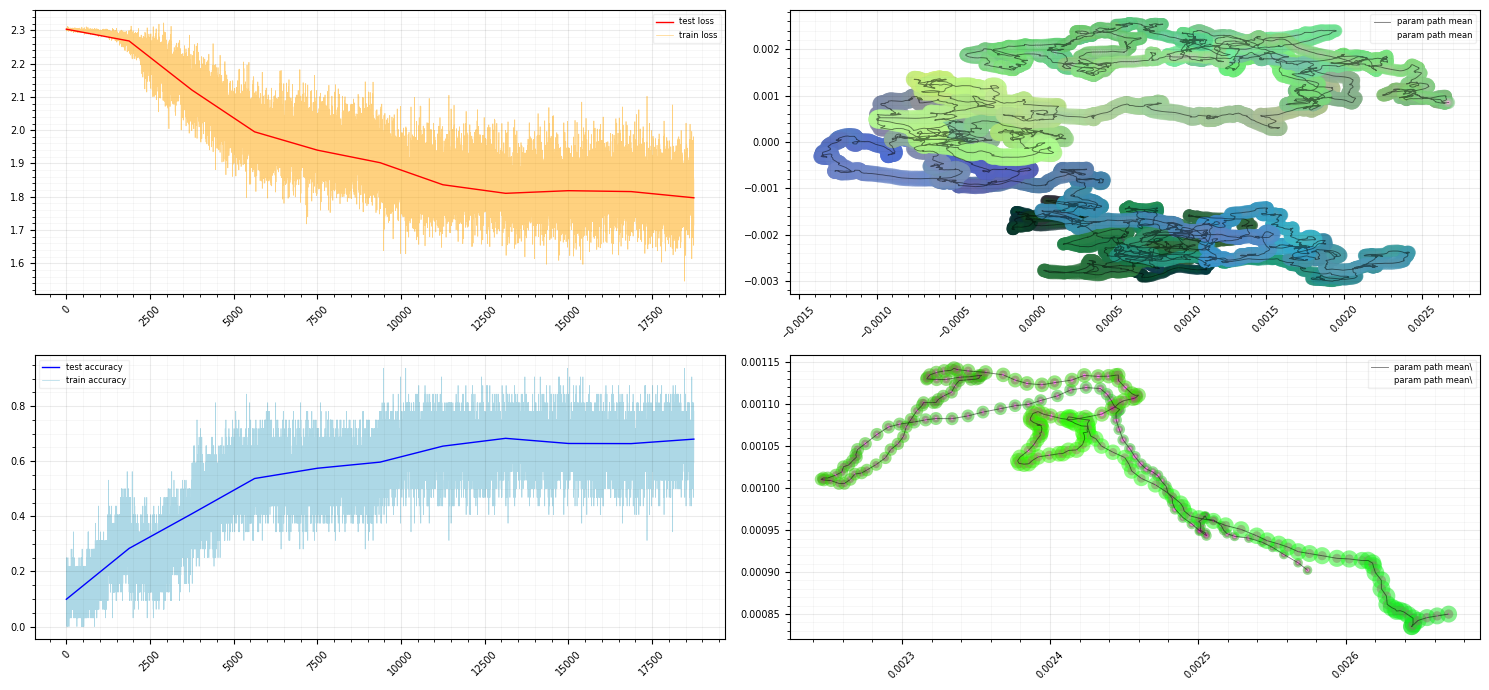

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 51.90s/ops, elapsed: 07m:47s, rem: 51.90s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 237.58ops/s, elapsed: 1.31s, rem: 4ms | 
train loss:                              last = 1.715, min = 1.547, max = 2.322
test loss:                               last = 1.816, min = 1.811, max = 2.303
train accuracy:                          last = 0.781, min = 0.000, max = 0.938
test accuracy:                           last = 0.664, min = 0.099, max = 0.683

test loss: min: 1.7971; max: 2.3029; last: 1.7971
test accuracy: min: 0.0989; max: 0.6832; last: 0.6803
param mean: min: -0.0001; max: 0.0036; last: 0.0035
param var: min: 0.0026; max: 0.0177; last: 0.0177
param min: min: -0.5406; max: -0.2501; last: -0.5106
param max: min: 0.2492; max: 0.6238; last: 0.6001
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0017; max: 0.0195; last: 0.0017
time: min: 2.5255; max: 519.4898; last: 519.4898
lr: min: 0.0000; max: 0.0000; last: 0.0000
train loss: min: 1.5470; max: 2.3218; last: 1.7150
train accuracy: min: 0.0000; max: 0.9375; last: 0.7812
last updates std: min: 0.0001; max: 0.0003; last: 0.0001


In [5]:
from torchzero.optim import RandomGrad
with seeded_rng(): MODEL = CNN()
LRGRAD = 1e-5
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomGrad(MODEL.parameters(), lr=LRGRAD, opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomGrad {LRGRAD:.0e} adamw{LR:.0e}"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# RandomGrad 1e-7 + AdamW 1e-3 - 44% test accuracy
... and 1e-7 is too low

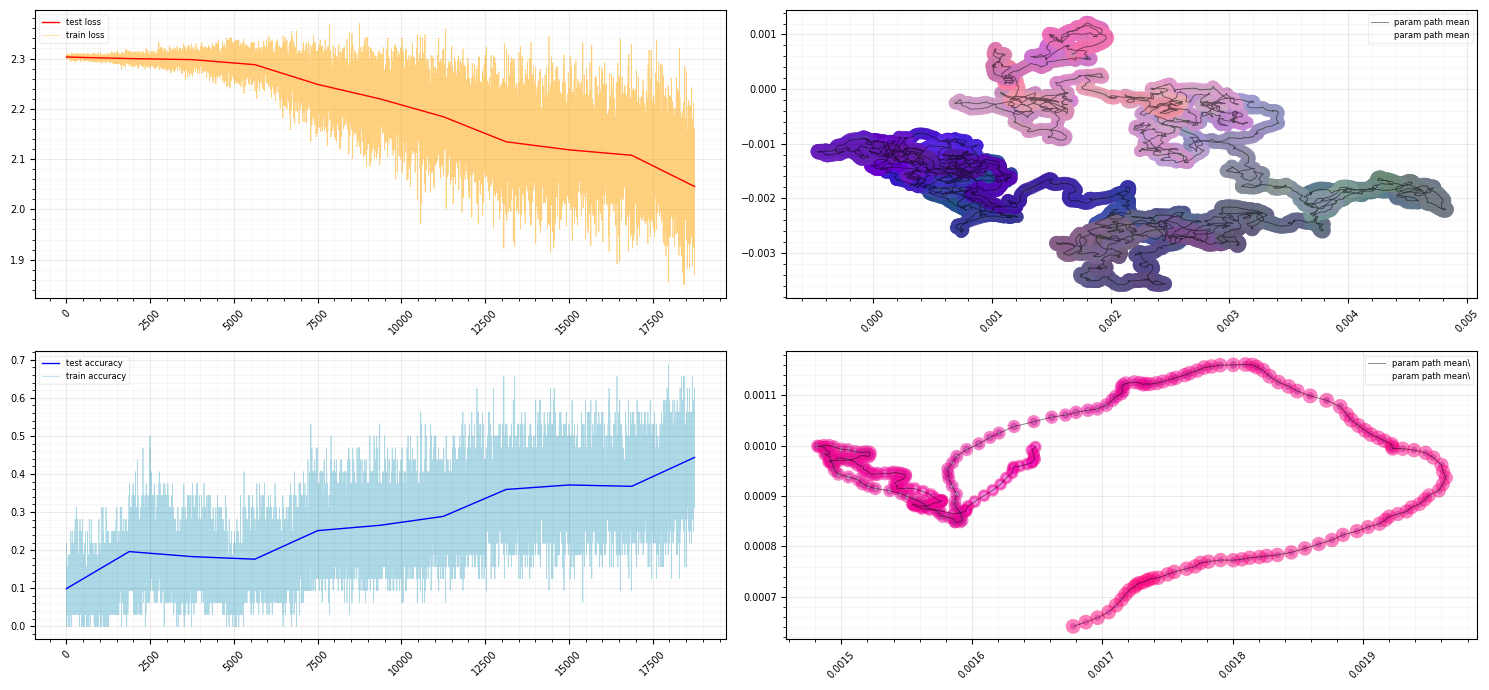

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 42.39s/ops, elapsed: 06m:21s, rem: 42.39s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 189.94ops/s, elapsed: 1.64s, rem: 5ms | 
train loss:                              last = 2.138, min = 1.850, max = 2.370
test loss:                               last = 2.108, min = 2.108, max = 2.303
train accuracy:                          last = 0.312, min = 0.000, max = 0.688
test accuracy:                           last = 0.368, min = 0.099, max = 0.371

test loss: min: 2.0455; max: 2.3029; last: 2.0455
test accuracy: min: 0.0989; max: 0.4436; last: 0.4436
param mean: min: -0.0000; max: 0.0023; last: 0.0023
param var: min: 0.0026; max: 0.0174; last: 0.0174
param min: min: -0.6625; max: -0.2484; last: -0.6579
param max: min: 0.2475; max: 0.5497; last: 0.5017
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0017; max: 0.0195; last: 0.0017
time: min: 2.2857; max: 432.3889; last: 432.3889
lr: min: 0.0000; max: 0.0000; last: 0.0000
train loss: min: 1.8498; max: 2.3704; last: 2.1380
train accuracy: min: 0.0000; max: 0.6875; last: 0.3125
last updates std: min: 0.0001; max: 0.0003; last: 0.0001


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [2]:
from torchzero.optim import RandomGrad
with seeded_rng(): MODEL = CNN()
LRGRAD = 1e-7
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomGrad(MODEL.parameters(), lr=LRGRAD, opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomGrad {LRGRAD:.0e} adamw{LR:.0e}"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# RandomBestGrad 1e-5 best of 10 + AdamW 1e-3 - 70% test accuracy
This does 11 evaluations per step as opposed to RandomGrad which does 2 - but it achieves higher accuracy with same learning rate, although it will let us get away with higher learning rates.

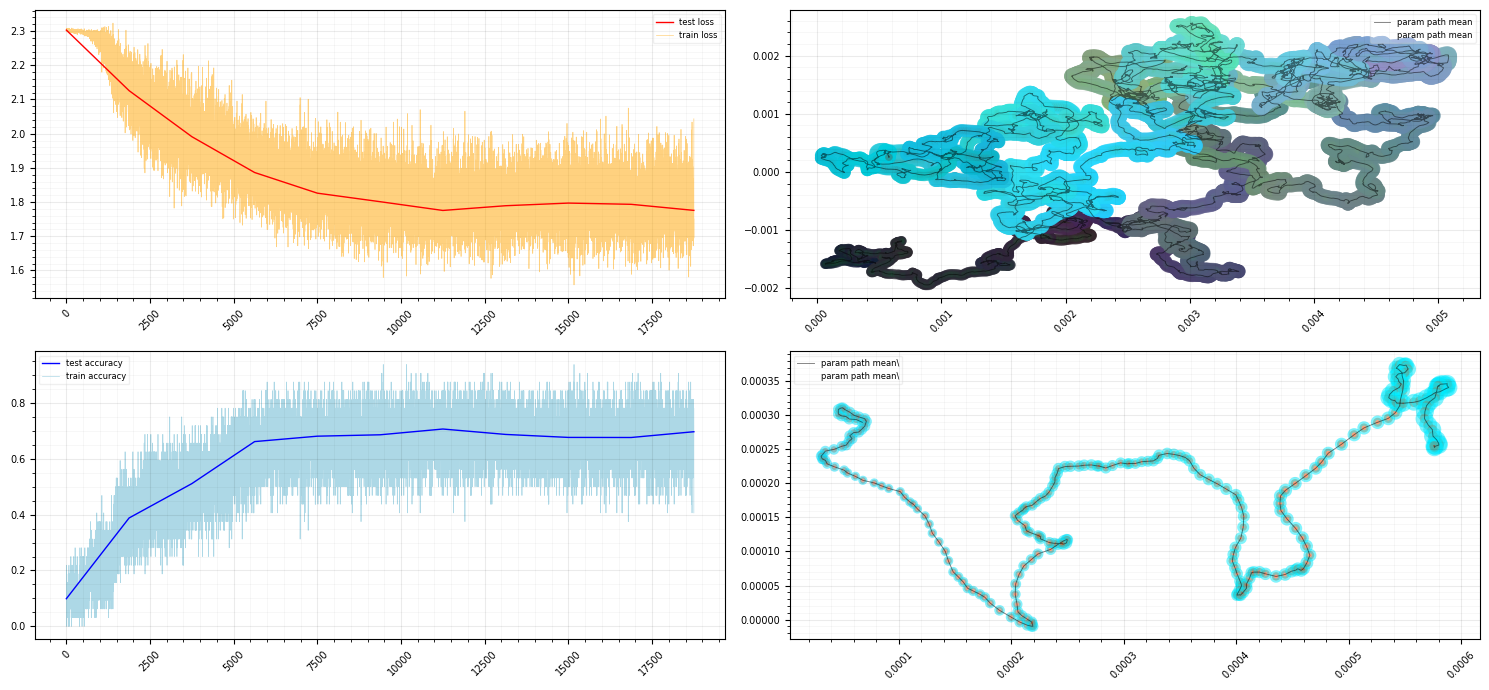

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:41s/ops, elapsed: 15m:09s, rem: 01m:41s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 231.99ops/s, elapsed: 1.34s, rem: 4ms | 
train loss:                              last = 2.043, min = 1.558, max = 2.323
test loss:                               last = 1.793, min = 1.775, max = 2.303
train accuracy:                          last = 0.406, min = 0.000, max = 0.938
test accuracy:                           last = 0.676, min = 0.099, max = 0.707

test loss: min: 1.7754; max: 2.3029; last: 1.7756
test accuracy: min: 0.0989; max: 0.7066; last: 0.6969
param mean: min: 0.0001; max: 0.0038; last: 0.0020
param var: min: 0.0026; max: 0.0175; last: 0.0175
param min: min: -0.5005; max: -0.2455; last: -0.4984
param max: min: 0.2409; max: 0.6003; last: 0.5595
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0017; max: 0.0195; last: 0.0017
time: min: 2.1491; max: 1035.9381; last: 1035.9381
lr: min: 0.0000; max: 0.0000; last: 0.0000
train loss: min: 1.5577; max: 2.3234; last: 2.0434
train accuracy: min: 0.0000; max: 0.9375; last: 0.4062
last updates std: min: 0.0000; max: 0.0003; last: 0.0001


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [2]:
from torchzero.optim import RandomBestGrad
with seeded_rng(): MODEL = CNN()
LRGRAD = 1e-5
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomBestGrad(MODEL.parameters(), lr=LRGRAD, bestof=10, opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomBestGrad {LRGRAD:.0e} adamw{LR:.0e} bestof10"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# RandomBestGrad 1e-5 best of 10 + AdamW 3e-3 - 57% test accuracy
This has the fastest convergence at the beginning - to 57% test accuracy in a single epoch, but then it stops improving.

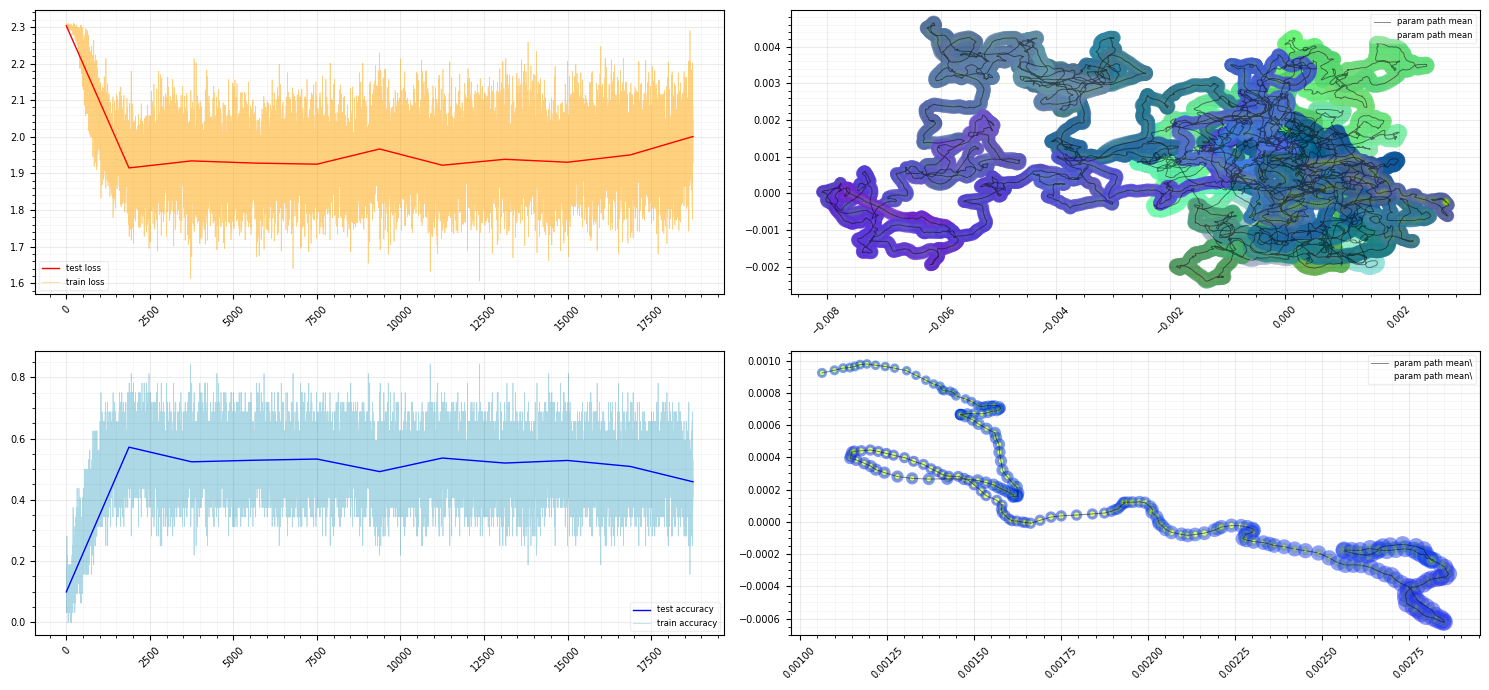

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 02m:09s/ops, elapsed: 19m:25s, rem: 02m:09s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 205.08ops/s, elapsed: 1.52s, rem: 5ms | 
train loss:                              last = 1.929, min = 1.606, max = 2.311
test loss:                               last = 1.951, min = 1.915, max = 2.303
train accuracy:                          last = 0.531, min = 0.000, max = 0.844
test accuracy:                           last = 0.509, min = 0.099, max = 0.572

test loss: min: 1.9150; max: 2.3029; last: 2.0007
test accuracy: min: 0.0989; max: 0.5719; last: 0.4588
param mean: min: -0.0033; max: 0.0030; last: -0.0025
param var: min: 0.0026; max: 0.1020; last: 0.1020
param min: min: -1.3669; max: -0.2524; last: -1.2832
param max: min: 0.2503; max: 1.3299; last: 1.2429
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0020; max: 0.0586; last: 0.0021
time: min: 1.8513; max: 1318.6669; last: 1318.6669
lr: min: 0.0000; max: 0.0000; last: 0.0000
train loss: min: 1.6060; max: 2.3108; last: 1.9289
train accuracy: min: 0.0000; max: 0.8438; last: 0.5312
last updates std: min: 0.0000; max: 0.0009; last: 0.0002


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [3]:
from torchzero.optim import RandomBestGrad
with seeded_rng(): MODEL = CNN()
LRGRAD = 1e-5
LR = 3e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomBestGrad(MODEL.parameters(), lr=LRGRAD, bestof=10, opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomBestGrad {LRGRAD:.0e} adamw{LR:.0e} bestof10"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# Swarm of RandomGrads
instead of using RandomBestGrad, we can use a swarm of 10 BestGrads with some enchancements, which gives better results.

Now each optimizer optimizes its own copy of model parameters, and, whenever some optimizer performs badly, it dies and respawns with new parameters that are a crossover between two best optimizers. This can also work on gradient-descent optimizers, but it will currently work bad with momentum and other custom update rules.

The path visualization is going to be all messed up because there are now separate particles evaluated sequentially and it tries to draw a path between all of them.

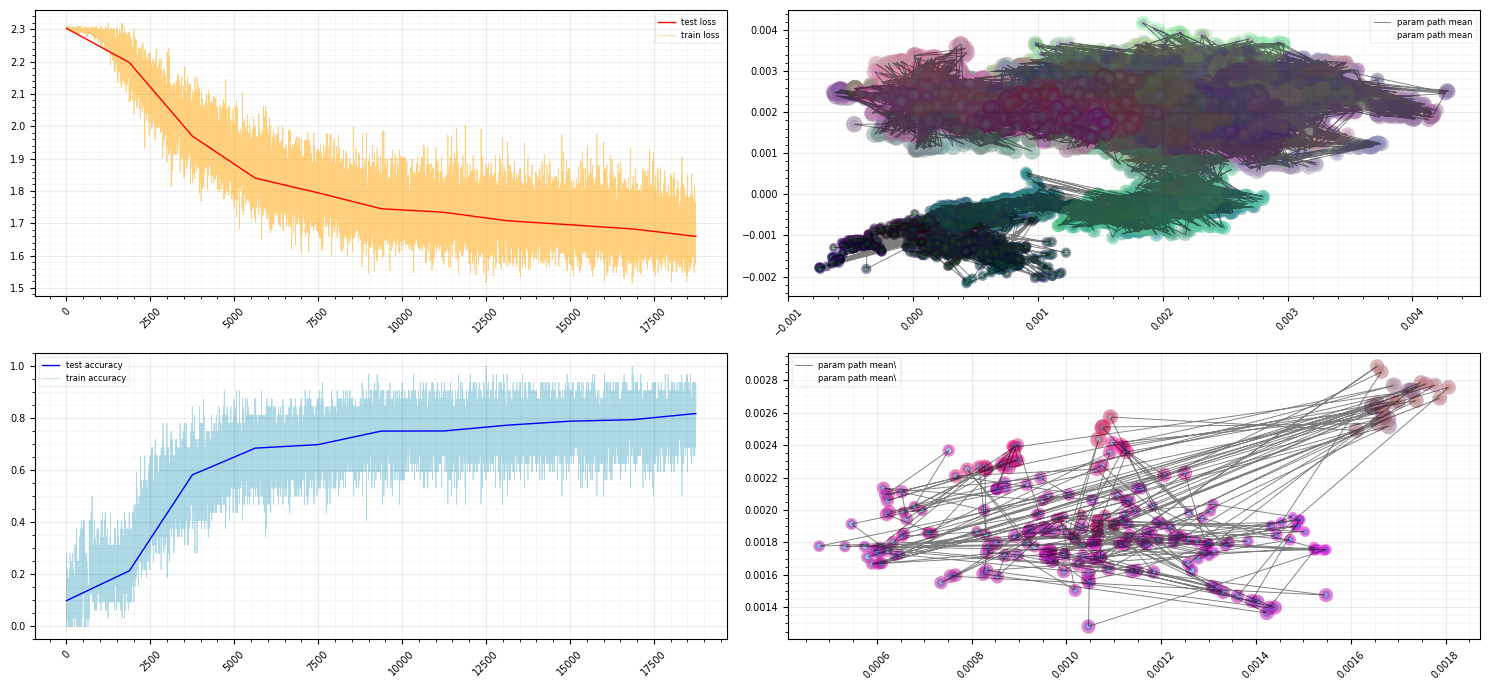

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 03m:47s/ops, elapsed: 34m:09s, rem: 03m:47s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 246.18ops/s, elapsed: 1.27s, rem: 4ms | 
train loss:                              last = 1.681, min = 1.515, max = 2.319
test loss:                               last = 1.682, min = 1.682, max = 2.303
train accuracy:                          last = 0.844, min = 0.000, max = 1.000
test accuracy:                           last = 0.795, min = 0.099, max = 0.795

test loss: min: 1.6595; max: 2.3029; last: 1.6595
test accuracy: min: 0.0989; max: 0.8182; last: 0.8182
param mean: min: -0.0004; max: 0.0042; last: 0.0037
param var: min: 0.0026; max: 0.0124; last: 0.0122
param min: min: -0.4737; max: -0.2472; last: -0.4228
param max: min: 0.2453; max: 0.5908; last: 0.5339
update var: min: 0.0000; max: 0.0008; last: 0.0000
update angle: min: 0.0021; max: 0.7790; last: 0.0097
time: min: 1.5171; max: 2248.3333; last: 2248.3333
train loss: min: 1.5146; max: 2.3193; last: 1.6811
train accuracy: min: 0.0000; max: 1.0000; last: 0.8438
last updates std: min: 0.0001; max: 0.0270; last: 0.0064


In [3]:
from torchzero.optim import RandomGrad, SwarmOfOptimizers
with seeded_rng(): MODEL = CNN()
LRGRAD = 1e-5
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

optimizers = [RandomGrad(MODEL.parameters(), lr=LRGRAD, opt=optim.AdamW(MODEL.parameters(), LR)) for _ in range(10)]
OPT = SwarmOfOptimizers(MODEL.parameters(), optimizers, old_steps=5, die_after=20, crossover_p=0.9)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"Swarm of RandomGrads {LRGRAD:.0e} adamw{LR:.0e} oldsteps5 dieafter20"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)